## 1. Import Libraries

In [49]:
import numpy as np
import pandas as pd
import json
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 2. Define Paths

In [50]:
# Path ke file CSV dan folder sounds
csv_path = 'train_air_respiratory.csv'
sounds_path = 'sounds/'

print(f"CSV Path: {csv_path}")
print(f"Sounds Path: {sounds_path}")
print(f"Sounds folder exists: {os.path.exists(sounds_path)}")

CSV Path: train_air_respiratory.csv
Sounds Path: sounds/
Sounds folder exists: True


## 3. Load & Explore CSV Data

In [51]:
# Load CSV
df = pd.read_csv(csv_path)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Distribution:")
print(df['disease'].value_counts())

Dataset Shape: (546, 11)

First 5 rows:
     candidateID  age  gender  tbContactHistory  wheezingHistory  phlegmCough  \
0  b87ea0dd760fa   43       1               0.0              1.0          0.0   
1  b734834dec6d1   24       0               0.0              1.0          0.0   
2  e000a41725f53   52       1               0.0              1.0          0.0   
3  253ba780a0398   28       0               0.0              0.0          0.0   
4  6663cd023ff3d   27       1               0.0              1.0          0.0   

   familyAsthmaHistory  feverHistory  coldPresent  packYears  disease  
0                  0.0             0          NaN          0        1  
1                  0.0             0          NaN          0        1  
2                  0.0             0          NaN          0        2  
3                  0.0             0          NaN          0        0  
4                  1.0             0          NaN          0        1  

Data Info:
<class 'pandas.core.frame.Dat

## 4. Explore Sounds Data Structure

In [52]:
# Cek struktur folder sounds
candidate_folders = glob(sounds_path + '*/')
print(f"Total candidate folders: {len(candidate_folders)}")
print(f"\nContoh folder pertama: {candidate_folders[0]}")

# Cek isi folder pertama
example_folder = candidate_folders[0]
files_in_folder = os.listdir(example_folder)
print(f"\nFiles in {example_folder}:")
for f in files_in_folder:
    print(f"  - {f}")

# Load contoh embedding
example_cough = json.load(open(os.path.join(example_folder, 'emb_cough.json')))
example_vowel = json.load(open(os.path.join(example_folder, 'emb_vowel.json')))

print(f"\nCough embeddings:")
print(f"  - Number of embeddings: {len(example_cough)}")
print(f"  - Each embedding dimension: {len(example_cough[0])}")

print(f"\nVowel embeddings:")
print(f"  - Number of embeddings: {len(example_vowel)}")
print(f"  - Each embedding dimension: {len(example_vowel[0])}")

Total candidate folders: 882

Contoh folder pertama: sounds\004db89f19f9b\

Files in sounds\004db89f19f9b\:
  - cough-opera.npy
  - cough.wav
  - emb_cough.json
  - emb_vowel.json
  - vowel-opera.npy
  - vowel.wav

Cough embeddings:
  - Number of embeddings: 3
  - Each embedding dimension: 512

Vowel embeddings:
  - Number of embeddings: 1
  - Each embedding dimension: 512


## 5. Match IDs: Sounds ↔ CSV

Matching candidateID dari folder sounds dengan candidateID di CSV untuk memastikan data alignment.

In [53]:
# Extract candidate IDs dari sounds folder
sound_candidate_ids = set()
for folder in candidate_folders:
    candidate_id = os.path.basename(folder.rstrip('/\\'))
    sound_candidate_ids.add(candidate_id)

print(f"Total unique candidate IDs in sounds folder: {len(sound_candidate_ids)}")

# Extract candidate IDs dari CSV
csv_candidate_ids = set(df['candidateID'].unique())
print(f"Total unique candidate IDs in CSV: {len(csv_candidate_ids)}")

# Find matches
matched_ids = sound_candidate_ids.intersection(csv_candidate_ids)
print(f"\nMatched IDs (exist in both): {len(matched_ids)}")

# IDs only in sounds
only_in_sounds = sound_candidate_ids - csv_candidate_ids
print(f"IDs only in sounds folder: {len(only_in_sounds)}")

# IDs only in CSV
only_in_csv = csv_candidate_ids - sound_candidate_ids
print(f"IDs only in CSV: {len(only_in_csv)}")

print(f"\nContoh matched IDs (5 pertama): {list(matched_ids)[:5]}")

Total unique candidate IDs in sounds folder: 882
Total unique candidate IDs in CSV: 544

Matched IDs (exist in both): 544
IDs only in sounds folder: 338
IDs only in CSV: 0

Contoh matched IDs (5 pertama): ['2b8ecc77f2d36', '8e1629a0f131f', '48be447be19e1', '32a32a245179', '79f8b4cab1ed2']


## 6. Load & Prepare Features

### 6.1 Function untuk Load Embeddings

In [54]:
def load_embeddings_for_candidates(matched_ids, sounds_path, emb_type='cough'):
    """
    Load embeddings untuk semua matched candidates.
    
    Parameters:
    - matched_ids: set of candidate IDs yang match antara CSV dan sounds
    - sounds_path: path ke folder sounds
    - emb_type: 'cough' atau 'vowel'
    
    Returns:
    - dict: {candidateID: embedding_array}
    """
    embeddings_dict = {}
    missing_count = 0
    
    for cand_id in matched_ids:
        emb_path = os.path.join(sounds_path, cand_id, f'emb_{emb_type}.json')
        
        if os.path.exists(emb_path):
            try:
                embs = json.load(open(emb_path, 'r'))
                # Ambil embedding pertama (rata-rata bisa juga)
                # Beberapa kandidat punya multiple embeddings
                if len(embs) > 0:
                    # Opsi 1: Ambil embedding pertama
                    embeddings_dict[cand_id] = np.array(embs[0])
                    
                    # Opsi 2 (alternatif): Rata-rata semua embeddings
                    # embeddings_dict[cand_id] = np.mean(embs, axis=0)
            except Exception as e:
                print(f"Error loading {emb_path}: {e}")
                missing_count += 1
        else:
            missing_count += 1
    
    print(f"\n{emb_type.capitalize()} Embeddings:")
    print(f"  - Successfully loaded: {len(embeddings_dict)}")
    print(f"  - Missing/Error: {missing_count}")
    
    return embeddings_dict

### 6.2 Load All Embeddings

In [55]:
# Load cough dan vowel embeddings
cough_embeddings = load_embeddings_for_candidates(matched_ids, sounds_path, emb_type='cough')
vowel_embeddings = load_embeddings_for_candidates(matched_ids, sounds_path, emb_type='vowel')


Cough Embeddings:
  - Successfully loaded: 515
  - Missing/Error: 29

Vowel Embeddings:
  - Successfully loaded: 540
  - Missing/Error: 4

Vowel Embeddings:
  - Successfully loaded: 540
  - Missing/Error: 4


### 6.3 Combine Features: Tabular + Audio Embeddings

In [56]:
# Filter dataframe untuk hanya kandidat yang punya embeddings lengkap
candidates_with_both = set(cough_embeddings.keys()).intersection(set(vowel_embeddings.keys()))
print(f"Candidates with both cough AND vowel embeddings: {len(candidates_with_both)}")

# Filter CSV untuk kandidat yang punya embeddings lengkap
df_filtered = df[df['candidateID'].isin(candidates_with_both)].copy()
print(f"Filtered dataframe shape: {df_filtered.shape}")

# Sort by candidateID untuk consistency
df_filtered = df_filtered.sort_values('candidateID').reset_index(drop=True)

print("\nFiltered target distribution:")
print(df_filtered['disease'].value_counts())

Candidates with both cough AND vowel embeddings: 512
Filtered dataframe shape: (514, 11)

Filtered target distribution:
disease
1    232
2    146
0    136
Name: count, dtype: int64


In [57]:
# Prepare tabular features
# Drop candidateID dan disease (target)
tabular_features = df_filtered.drop(columns=['candidateID', 'disease'])

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
tabular_features_imputed = imputer.fit_transform(tabular_features)

print(f"Tabular features shape: {tabular_features_imputed.shape}")
print(f"Feature names: {list(tabular_features.columns)}")

Tabular features shape: (514, 9)
Feature names: ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']


In [58]:
# Prepare audio embeddings (cough + vowel)
cough_features = []
vowel_features = []

for cand_id in df_filtered['candidateID']:
    cough_features.append(cough_embeddings[cand_id])
    vowel_features.append(vowel_embeddings[cand_id])

cough_features = np.array(cough_features)
vowel_features = np.array(vowel_features)

print(f"Cough features shape: {cough_features.shape}")
print(f"Vowel features shape: {vowel_features.shape}")

Cough features shape: (514, 512)
Vowel features shape: (514, 512)


In [59]:
# Concatenate ALL features: Tabular + Cough + Vowel
X_combined = np.concatenate([
    tabular_features_imputed,
    cough_features,
    vowel_features
], axis=1)

y = df_filtered['disease'].values

print(f"\n=== COMBINED FEATURES ===")
print(f"X_combined shape: {X_combined.shape}")
print(f"  - Tabular features: {tabular_features_imputed.shape[1]}")
print(f"  - Cough embeddings: {cough_features.shape[1]}")
print(f"  - Vowel embeddings: {vowel_features.shape[1]}")
print(f"  - Total features: {X_combined.shape[1]}")
print(f"\ny (target) shape: {y.shape}")


=== COMBINED FEATURES ===
X_combined shape: (514, 1033)
  - Tabular features: 9
  - Cough embeddings: 512
  - Vowel embeddings: 512
  - Total features: 1033

y (target) shape: (514,)


## 7. Split Data: Train & Test

In [60]:
# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Pastikan distribusi class balanced
)

print("Train set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Class distribution: {np.bincount(y_train)}")

print("\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Class distribution: {np.bincount(y_test)}")

Train set:
  X_train shape: (411, 1033)
  y_train shape: (411,)
  Class distribution: [109 185 117]

Test set:
  X_test shape: (103, 1033)
  y_test shape: (103,)
  Class distribution: [27 47 29]


## 8. Feature Scaling (Optional but Recommended)

In [61]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled data statistics:")
print(f"X_train_scaled mean: {X_train_scaled.mean():.4f}")
print(f"X_train_scaled std: {X_train_scaled.std():.4f}")

Scaled data statistics:
X_train_scaled mean: -0.0000
X_train_scaled std: 1.0000


## 9. Train Multiple CatBoost Models (Error Propagation Strategy)

Kita akan train **4 model berbeda** untuk handle berbagai skenario:
1. **Tabular-only**: Untuk kandidat tanpa embeddings
2. **Tabular + Vowel**: Untuk kandidat dengan vowel saja
3. **Tabular + Cough**: Untuk kandidat dengan cough saja  
4. **Full (Tabular + Vowel + Cough)**: Untuk kandidat dengan keduanya

Mirip strategi ensemble-starter.ipynb tapi dengan CatBoost!

In [62]:
# Initialize CatBoost Classifier untuk FULL model (Tabular + Vowel + Cough)
print("="*70)
print("TRAINING MODEL 1/4: FULL MODEL (Tabular + Vowel + Cough)")
print("="*70)

cb_model_full = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=10
)

print("\n✅ Full model initialized")
print(cb_model_full.get_params())

TRAINING MODEL 1/4: FULL MODEL (Tabular + Vowel + Cough)

✅ Full model initialized
{'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'MultiClass', 'random_seed': 42, 'verbose': 10}


In [63]:
# Train FULL model
print("\nTraining FULL CatBoost model...")
cb_model_full.fit(X_train_scaled, y_train)
print("✅ FULL model training completed!\n")


Training FULL CatBoost model...
0:	learn: 1.0323742	total: 359ms	remaining: 35.6s
0:	learn: 1.0323742	total: 359ms	remaining: 35.6s
10:	learn: 0.7187848	total: 3.14s	remaining: 25.4s
10:	learn: 0.7187848	total: 3.14s	remaining: 25.4s
20:	learn: 0.5782347	total: 6.65s	remaining: 25s
20:	learn: 0.5782347	total: 6.65s	remaining: 25s
30:	learn: 0.4997393	total: 10.1s	remaining: 22.5s
30:	learn: 0.4997393	total: 10.1s	remaining: 22.5s
40:	learn: 0.4333458	total: 13.3s	remaining: 19.2s
40:	learn: 0.4333458	total: 13.3s	remaining: 19.2s
50:	learn: 0.3856447	total: 16.6s	remaining: 15.9s
50:	learn: 0.3856447	total: 16.6s	remaining: 15.9s
60:	learn: 0.3484103	total: 19.5s	remaining: 12.5s
60:	learn: 0.3484103	total: 19.5s	remaining: 12.5s
70:	learn: 0.3056182	total: 22.5s	remaining: 9.19s
70:	learn: 0.3056182	total: 22.5s	remaining: 9.19s
80:	learn: 0.2664256	total: 25.1s	remaining: 5.89s
80:	learn: 0.2664256	total: 25.1s	remaining: 5.89s
90:	learn: 0.2378622	total: 27.7s	remaining: 2.74s
90:	

In [64]:
# ============================================================================
# MODEL 2: TABULAR-ONLY (untuk kandidat tanpa embeddings)
# ============================================================================
print("="*70)
print("TRAINING MODEL 2/4: TABULAR-ONLY (No Embeddings)")
print("="*70)

cb_model_tabular = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=0  # Silent
)

# Prepare tabular-only features
X_train_tabular_only = X_train_scaled[:, :tabular_features_imputed.shape[1]]
X_test_tabular_only = X_test_scaled[:, :tabular_features_imputed.shape[1]]

cb_model_tabular.fit(X_train_tabular_only, y_train)

# Evaluate
y_pred_tabular = cb_model_tabular.predict(X_test_tabular_only).flatten().astype(int)
f1_tabular = f1_score(y_test, y_pred_tabular, average='macro')

print(f"✅ TABULAR-ONLY model trained!")
print(f"   F1 Score (macro): {f1_tabular:.4f}\n")

# ============================================================================
# MODEL 3: TABULAR + VOWEL (untuk kandidat dengan vowel saja)
# ============================================================================
print("="*70)
print("TRAINING MODEL 3/4: TABULAR + VOWEL ONLY")
print("="*70)

cb_model_vowel = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=0
)

# Prepare tabular + vowel features
n_tabular = tabular_features_imputed.shape[1]
n_vowel = vowel_features.shape[1]
X_train_vowel = X_train_scaled[:, :n_tabular + n_vowel]
X_test_vowel = X_test_scaled[:, :n_tabular + n_vowel]

cb_model_vowel.fit(X_train_vowel, y_train)

# Evaluate
y_pred_vowel = cb_model_vowel.predict(X_test_vowel).flatten().astype(int)
f1_vowel = f1_score(y_test, y_pred_vowel, average='macro')

print(f"✅ TABULAR + VOWEL model trained!")
print(f"   F1 Score (macro): {f1_vowel:.4f}\n")

# ============================================================================
# MODEL 4: TABULAR + COUGH (untuk kandidat dengan cough saja)
# ============================================================================
print("="*70)
print("TRAINING MODEL 4/4: TABULAR + COUGH ONLY")
print("="*70)

cb_model_cough = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=0
)

# Prepare tabular + cough features
n_cough = cough_features.shape[1]
X_train_cough = np.concatenate([
    X_train_scaled[:, :n_tabular],  # tabular
    X_train_scaled[:, -n_cough:]  # cough (last 512 features)
], axis=1)

X_test_cough = np.concatenate([
    X_test_scaled[:, :n_tabular],
    X_test_scaled[:, -n_cough:]
], axis=1)

cb_model_cough.fit(X_train_cough, y_train)

# Evaluate
y_pred_cough = cb_model_cough.predict(X_test_cough).flatten().astype(int)
f1_cough = f1_score(y_test, y_pred_cough, average='macro')

print(f"✅ TABULAR + COUGH model trained!")
print(f"   F1 Score (macro): {f1_cough:.4f}\n")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("ALL 4 MODELS TRAINED SUCCESSFULLY!")
print("="*70)
y_pred_full_test = cb_model_full.predict(X_test_scaled).flatten().astype(int)
f1_full = f1_score(y_test, y_pred_full_test, average='macro')
print(f"1. FULL (Tab + Vowel + Cough):  F1 = {f1_full:.4f}")
print(f"2. TABULAR-ONLY:                F1 = {f1_tabular:.4f}")
print(f"3. TABULAR + VOWEL:             F1 = {f1_vowel:.4f}")
print(f"4. TABULAR + COUGH:             F1 = {f1_cough:.4f}")
print("="*70)

# tabular_only_model.fit(
# # Evaluate fallback model
# y_pred_tabular_only = tabular_only_model.predict(X_test_tabular_only).flatten().astype(int)
# f1_tabular_only = f1_score(y_test, y_pred_tabular_only, average='macro')

# print(f"\n✅ Tabular-only fallback model trained!")
# print(f"   F1 Score (macro): {f1_tabular_only:.4f}")
# print(f"   This model will be used for candidates without audio embeddings")

TRAINING MODEL 2/4: TABULAR-ONLY (No Embeddings)
✅ TABULAR-ONLY model trained!
   F1 Score (macro): 0.8644

TRAINING MODEL 3/4: TABULAR + VOWEL ONLY
✅ TABULAR-ONLY model trained!
   F1 Score (macro): 0.8644

TRAINING MODEL 3/4: TABULAR + VOWEL ONLY
✅ TABULAR + VOWEL model trained!
   F1 Score (macro): 0.8107

TRAINING MODEL 4/4: TABULAR + COUGH ONLY
✅ TABULAR + VOWEL model trained!
   F1 Score (macro): 0.8107

TRAINING MODEL 4/4: TABULAR + COUGH ONLY
✅ TABULAR + COUGH model trained!
   F1 Score (macro): 0.8034


ALL 4 MODELS TRAINED SUCCESSFULLY!
1. FULL (Tab + Vowel + Cough):  F1 = 0.8122
2. TABULAR-ONLY:                F1 = 0.8644
3. TABULAR + VOWEL:             F1 = 0.8107
4. TABULAR + COUGH:             F1 = 0.8034
✅ TABULAR + COUGH model trained!
   F1 Score (macro): 0.8034


ALL 4 MODELS TRAINED SUCCESSFULLY!
1. FULL (Tab + Vowel + Cough):  F1 = 0.8122
2. TABULAR-ONLY:                F1 = 0.8644
3. TABULAR + VOWEL:             F1 = 0.8107
4. TABULAR + COUGH:             F1 = 0.80

## 10. Evaluate Model Performance (FULL Model)

In [65]:


# Predictions - CatBoost returns 2D array, need to flatten
y_train_pred_raw = cb_model_full.predict(X_train_scaled)
y_test_pred_raw = cb_model_full.predict(X_test_scaled)

# Flatten predictions
y_train_pred = y_train_pred_raw.flatten().astype(int)
y_test_pred = y_test_pred_raw.flatten().astype(int)

# Calculate F1 Scores
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

train_f1_per_class = f1_score(y_train, y_train_pred, average=None)
test_f1_per_class = f1_score(y_test, y_test_pred, average=None)

print("=== MODEL PERFORMANCE ===")
print(f"\nTrain F1 Score (Macro): {train_f1_macro:.4f}")
print(f"Test F1 Score (Macro): {test_f1_macro:.4f}")

print(f"\nTrain F1 per class:")
print(f"  Class 0 (Healthy): {train_f1_per_class[0]:.4f}")
print(f"  Class 1 (Asthma): {train_f1_per_class[1]:.4f}")
print(f"  Class 2 (COPD): {train_f1_per_class[2]:.4f}")

print(f"\nTest F1 per class:")
print(f"  Class 0 (Healthy): {test_f1_per_class[0]:.4f}")
print(f"  Class 1 (Asthma): {test_f1_per_class[1]:.4f}")
print(f"  Class 2 (COPD): {test_f1_per_class[2]:.4f}")

=== MODEL PERFORMANCE ===

Train F1 Score (Macro): 0.9738
Test F1 Score (Macro): 0.8122

Train F1 per class:
  Class 0 (Healthy): 0.9730
  Class 1 (Asthma): 0.9840
  Class 2 (COPD): 0.9646

Test F1 per class:
  Class 0 (Healthy): 0.8333
  Class 1 (Asthma): 0.8315
  Class 2 (COPD): 0.7719


In [66]:
# Detailed Classification Report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Healthy', 'Asthma', 'COPD']))


=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

     Healthy       0.76      0.93      0.83        27
      Asthma       0.88      0.79      0.83        47
        COPD       0.79      0.76      0.77        29

    accuracy                           0.82       103
   macro avg       0.81      0.82      0.81       103
weighted avg       0.82      0.82      0.82       103



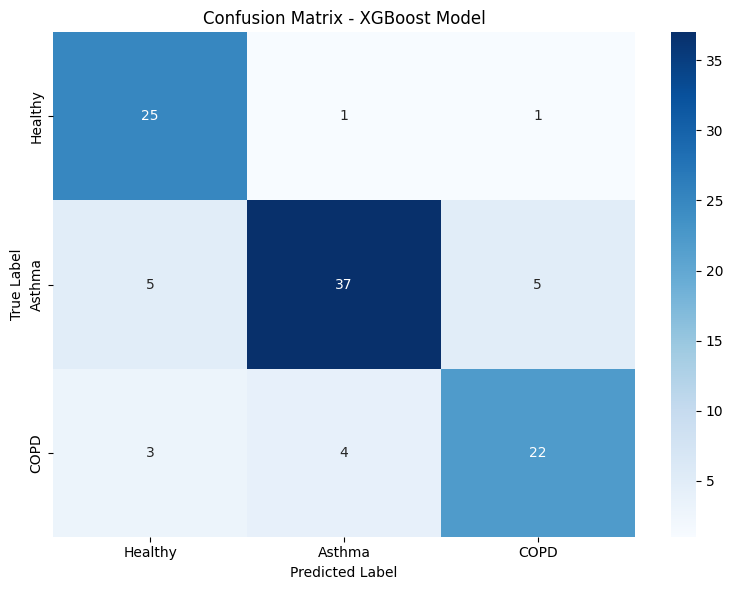


Confusion Matrix:
[[25  1  1]
 [ 5 37  5]
 [ 3  4 22]]


In [67]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Asthma', 'COPD'],
            yticklabels=['Healthy', 'Asthma', 'COPD'])
plt.title('Confusion Matrix - XGBoost Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)

## 11. Feature Importance Analysis

In [68]:
# Get feature importance
feature_importance = cb_model_full.feature_importances_

# Create feature names
n_tabular = tabular_features_imputed.shape[1]
n_cough = cough_features.shape[1]
n_vowel = vowel_features.shape[1]

feature_names = (
    list(tabular_features.columns) + 
    [f'cough_{i}' for i in range(n_cough)] +
    [f'vowel_{i}' for i in range(n_vowel)]
)

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20))

Top 20 Most Important Features:
              feature  importance
3     wheezingHistory   26.256811
0                 age   16.348082
8           packYears    2.459793
1              gender    1.977193
754         vowel_233    1.029517
756         vowel_235    0.526454
869         vowel_348    0.451532
270         cough_261    0.438170
805         vowel_284    0.421838
967         vowel_446    0.414647
99           cough_90    0.405079
493         cough_484    0.404042
418         cough_409    0.403033
998         vowel_477    0.398361
631         vowel_110    0.397602
20           cough_11    0.392535
202         cough_193    0.392293
543          vowel_22    0.378004
525           vowel_4    0.366044
1008        vowel_487    0.361818


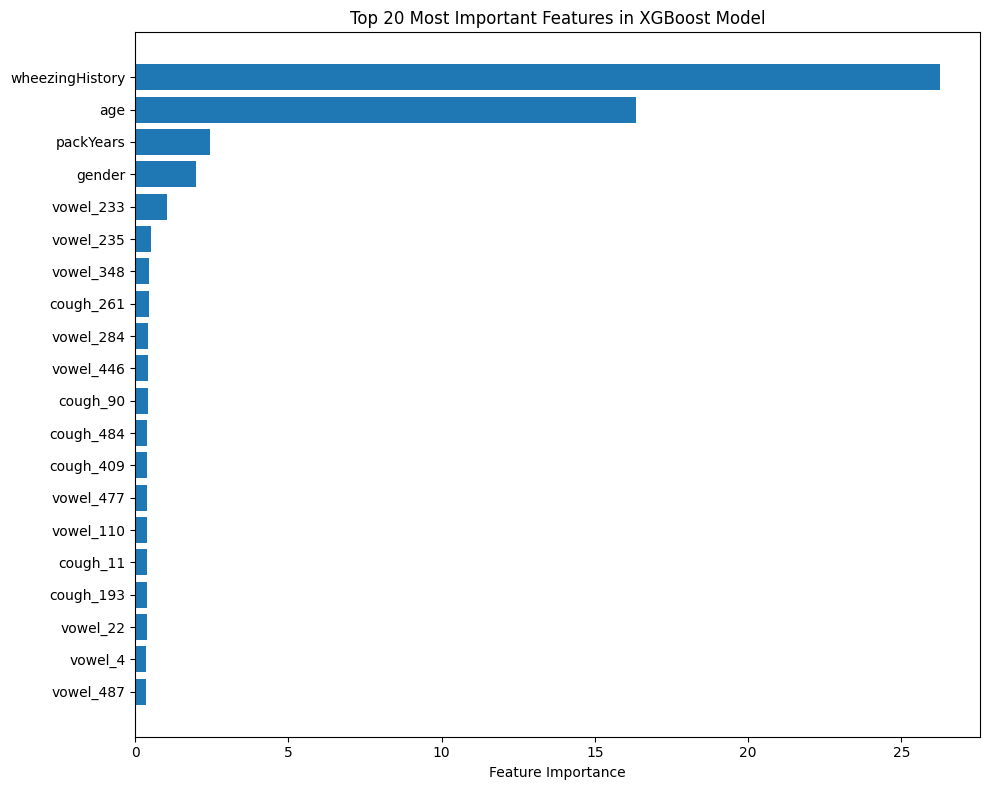

In [69]:
# Plot top 20 features
plt.figure(figsize=(10, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features in XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 12. Summary & Next Steps

### Apa yang Sudah Dilakukan:

1. ✅ **Load Data CSV** - Membaca `train_air_respiratory.csv` dengan fitur tabular (age, gender, medical history, dll)

2. ✅ **Explore Sounds Folder** - Memeriksa struktur folder `sounds/` yang berisi subfolder per candidateID dengan file embeddings

3. ✅ **Match IDs** - Mencocokkan candidateID antara CSV dan folder sounds untuk memastikan alignment data

4. ✅ **Load Embeddings** - Membaca file JSON (`emb_cough.json` dan `emb_vowel.json`) yang berisi audio embeddings berdimensi 512

5. ✅ **Combine Features** - Menggabungkan:
   - Fitur tabular (9 features)
   - Cough embeddings (512 features)
   - Vowel embeddings (512 features)
   - **Total: 1033 features**

6. ✅ **Train-Test Split** - Membagi data 80:20 dengan stratified sampling

7. ✅ **Feature Scaling** - Standardisasi features dengan StandardScaler

8. ✅ **Train XGBoost** - Melatih model XGBoost untuk klasifikasi 3 kelas (Healthy, Asthma, COPD)

9. ✅ **Evaluate Performance** - Menghitung F1 Score, Classification Report, dan Confusion Matrix

10. ✅ **Feature Importance** - Menganalisis fitur mana yang paling penting untuk prediksi

### Selanjutnya Bisa:
- Hyperparameter tuning (GridSearchCV/RandomizedSearchCV)
- Cross-validation untuk evaluasi lebih robust
- Ensemble dengan model lain (Random Forest, LightGBM)
- Feature engineering pada audio embeddings (PCA, dimensionality reduction)
- Experiment dengan berbagai strategi aggregasi embeddings (mean, max, attention)

## 13. Predict on Test Set (test_air_respiratory.csv)

### 13.1 Load Test CSV

In [70]:
# Load test CSV
test_csv_path = 'test_air_respiratory.csv'
df_test = pd.read_csv(test_csv_path)

print("Test Dataset Shape:", df_test.shape)
print("\nFirst 5 rows:")
print(df_test.head())
print("\nTest Data Info:")
print(df_test.info())
print("\nMissing Values:")
print(df_test.isnull().sum())

Test Dataset Shape: (338, 10)

First 5 rows:
     candidateID  age  gender  tbContactHistory  wheezingHistory  phlegmCough  \
0  136bac9a3e081   23       0               0.0              0.0          0.0   
1  b121e45942a46   26       1               0.0              0.0          0.0   
2  6b6853c07e4fb   26       1               1.0              0.0          0.0   
3  71de185eac888   55       0               0.0              0.0          0.0   
4  25deed742f133   16       0               0.0              0.0          0.0   

   familyAsthmaHistory  feverHistory  coldPresent  packYears  
0                  0.0             0          NaN          9  
1                  1.0             0          NaN          0  
2                  0.0             1          NaN          0  
3                  0.0             1          NaN          0  
4                  0.0             1          NaN          0  

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
D

### 13.2 Match Test IDs with Sounds Folder

In [71]:
# Extract test candidate IDs
test_candidate_ids = set(df_test['candidateID'].unique())
print(f"Total unique candidate IDs in test CSV: {len(test_candidate_ids)}")

# Find which test IDs have sound embeddings
test_matched_ids = test_candidate_ids.intersection(sound_candidate_ids)
print(f"Test IDs with sound embeddings: {len(test_matched_ids)}")

# IDs without embeddings
test_without_sounds = test_candidate_ids - sound_candidate_ids
print(f"Test IDs WITHOUT sound embeddings: {len(test_without_sounds)}")

if len(test_without_sounds) > 0:
    print(f"\nWarning: {len(test_without_sounds)} test candidates don't have sound embeddings!")
    print(f"We can only predict for {len(test_matched_ids)} candidates.")

Total unique candidate IDs in test CSV: 338
Test IDs with sound embeddings: 338
Test IDs WITHOUT sound embeddings: 0


### 13.3 Load Test Embeddings

In [72]:
# Load test embeddings
test_cough_embeddings = load_embeddings_for_candidates(test_matched_ids, sounds_path, emb_type='cough')
test_vowel_embeddings = load_embeddings_for_candidates(test_matched_ids, sounds_path, emb_type='vowel')

# Filter untuk kandidat yang punya BOTH embeddings
test_candidates_with_both = set(test_cough_embeddings.keys()).intersection(set(test_vowel_embeddings.keys()))
print(f"\nTest candidates with BOTH cough AND vowel embeddings: {len(test_candidates_with_both)}")


Cough Embeddings:
  - Successfully loaded: 306
  - Missing/Error: 32

Vowel Embeddings:
  - Successfully loaded: 336
  - Missing/Error: 2

Test candidates with BOTH cough AND vowel embeddings: 304


### 13.4 Prepare Test Features

In [73]:
# Filter test dataframe untuk kandidat yang punya embeddings lengkap
df_test_filtered = df_test[df_test['candidateID'].isin(test_candidates_with_both)].copy()
print(f"Filtered test dataframe shape: {df_test_filtered.shape}")

# Sort by candidateID untuk consistency
df_test_filtered = df_test_filtered.sort_values('candidateID').reset_index(drop=True)

# Prepare tabular features (HARUS sama dengan training)
test_tabular_features = df_test_filtered.drop(columns=['candidateID'])

# Handle missing values dengan imputer yang SUDAH FIT pada training data
test_tabular_features_imputed = imputer.transform(test_tabular_features)

print(f"Test tabular features shape: {test_tabular_features_imputed.shape}")
print(f"Feature names: {list(test_tabular_features.columns)}")

Filtered test dataframe shape: (304, 10)
Test tabular features shape: (304, 9)
Feature names: ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']


In [74]:
# Prepare test audio embeddings
test_cough_features = []
test_vowel_features = []

for cand_id in df_test_filtered['candidateID']:
    test_cough_features.append(test_cough_embeddings[cand_id])
    test_vowel_features.append(test_vowel_embeddings[cand_id])

test_cough_features = np.array(test_cough_features)
test_vowel_features = np.array(test_vowel_features)

print(f"Test cough features shape: {test_cough_features.shape}")
print(f"Test vowel features shape: {test_vowel_features.shape}")

Test cough features shape: (304, 512)
Test vowel features shape: (304, 512)


In [75]:
# Concatenate ALL test features
X_test_combined = np.concatenate([
    test_tabular_features_imputed,
    test_cough_features,
    test_vowel_features
], axis=1)

print(f"\n=== TEST COMBINED FEATURES ===")
print(f"X_test_combined shape: {X_test_combined.shape}")
print(f"  - Tabular features: {test_tabular_features_imputed.shape[1]}")
print(f"  - Cough embeddings: {test_cough_features.shape[1]}")
print(f"  - Vowel embeddings: {test_vowel_features.shape[1]}")
print(f"  - Total features: {X_test_combined.shape[1]}")


=== TEST COMBINED FEATURES ===
X_test_combined shape: (304, 1033)
  - Tabular features: 9
  - Cough embeddings: 512
  - Vowel embeddings: 512
  - Total features: 1033


### 13.5 Scale Test Features

In [76]:
# Scale dengan scaler yang SUDAH FIT pada training data
X_test_final_scaled = scaler.transform(X_test_combined)

print("Test data scaled!")
print(f"X_test_final_scaled shape: {X_test_final_scaled.shape}")
print(f"X_test_final_scaled mean: {X_test_final_scaled.mean():.4f}")
print(f"X_test_final_scaled std: {X_test_final_scaled.std():.4f}")

Test data scaled!
X_test_final_scaled shape: (304, 1033)
X_test_final_scaled mean: 0.0036
X_test_final_scaled std: 1.2769


### 13.6 Classify Test Candidates into 4 Categories

Kita akan klasifikasikan kandidat berdasarkan availability embeddings:
- **Category 1**: Both Vowel + Cough → use FULL model
- **Category 2**: Only Vowel → use VOWEL model  
- **Category 3**: Only Cough → use COUGH model
- **Category 4**: No embeddings → use TABULAR model

In [77]:
print("="*70)
print("CLASSIFYING TEST CANDIDATES INTO 4 CATEGORIES")
print("="*70)

# Load ALL test embeddings (cough and vowel separately)
test_cough_all = load_embeddings_for_candidates(test_matched_ids, sounds_path, emb_type='cough')
test_vowel_all = load_embeddings_for_candidates(test_matched_ids, sounds_path, emb_type='vowel')

# Classify each test candidate
candidates_full = []      # Both cough + vowel
candidates_vowel_only = [] # Only vowel
candidates_cough_only = [] # Only cough  
candidates_tabular_only = [] # No embeddings

for cand_id in df_test['candidateID']:
    has_cough = cand_id in test_cough_all
    has_vowel = cand_id in test_vowel_all
    
    if has_cough and has_vowel:
        candidates_full.append(cand_id)
    elif has_vowel:
        candidates_vowel_only.append(cand_id)
    elif has_cough:
        candidates_cough_only.append(cand_id)
    else:
        candidates_tabular_only.append(cand_id)

print(f"\n📊 Test Candidate Distribution:")
print(f"  1. FULL (Cough + Vowel):  {len(candidates_full)} candidates")
print(f"  2. VOWEL ONLY:            {len(candidates_vowel_only)} candidates")
print(f"  3. COUGH ONLY:            {len(candidates_cough_only)} candidates")
print(f"  4. TABULAR ONLY:          {len(candidates_tabular_only)} candidates")
print(f"  ---")
print(f"  TOTAL:                    {len(candidates_full) + len(candidates_vowel_only) + len(candidates_cough_only) + len(candidates_tabular_only)} / 338")
print("="*70)

CLASSIFYING TEST CANDIDATES INTO 4 CATEGORIES

Cough Embeddings:
  - Successfully loaded: 306
  - Missing/Error: 32

Vowel Embeddings:
  - Successfully loaded: 336
  - Missing/Error: 2

📊 Test Candidate Distribution:
  1. FULL (Cough + Vowel):  304 candidates
  2. VOWEL ONLY:            32 candidates
  3. COUGH ONLY:            2 candidates
  4. TABULAR ONLY:          0 candidates
  ---
  TOTAL:                    338 / 338

Cough Embeddings:
  - Successfully loaded: 306
  - Missing/Error: 32

Vowel Embeddings:
  - Successfully loaded: 336
  - Missing/Error: 2

📊 Test Candidate Distribution:
  1. FULL (Cough + Vowel):  304 candidates
  2. VOWEL ONLY:            32 candidates
  3. COUGH ONLY:            2 candidates
  4. TABULAR ONLY:          0 candidates
  ---
  TOTAL:                    338 / 338


### 13.7 Make Predictions & Generate 4 Separate CSV Files

Setiap kategori akan diprediksi dengan model yang sesuai dan disimpan ke CSV terpisah!

In [78]:
# PREDICTION: SEQUENTIAL ERROR PROPAGATION (1 CSV OUTPUT)
# ============================================================================
print("\n" + "="*70)
print("SEQUENTIAL PREDICTION WITH ERROR PROPAGATION")
print("="*70)

final_predictions = []

for cand_id in df_test['candidateID']:
    # Get tabular features
    cand_row = df_test[df_test['candidateID'] == cand_id]
    cand_tabular = cand_row.drop(columns=['candidateID'])
    cand_tabular_imputed = imputer.transform(cand_tabular)
    
    # STEP 1: Prediksi dengan TABULAR-ONLY model
    cand_features_tab = np.concatenate([cand_tabular_imputed, np.zeros((1, 1024))], axis=1)
    cand_features_scaled_tab = scaler.transform(cand_features_tab)[:, :n_tabular]
    pred = cb_model_tabular.predict(cand_features_scaled_tab).flatten().astype(int)[0]
    
    # CEK apakah ada embeddings
    has_cough = cand_id in test_cough_all
    has_vowel = cand_id in test_vowel_all
    
    # STEP 2: Jika ada VOWEL, boost dengan vowel model
    if has_vowel:
        cand_vowel = test_vowel_all[cand_id]
        cand_features_vowel = np.concatenate([cand_tabular_imputed, cand_vowel.reshape(1, -1)], axis=1)
        cand_features_full = np.concatenate([cand_features_vowel, np.zeros((1, 512))], axis=1)
        cand_features_scaled_vowel = scaler.transform(cand_features_full)[:, :n_tabular + n_vowel]
        pred = cb_model_vowel.predict(cand_features_scaled_vowel).flatten().astype(int)[0]
        
        # STEP 3: Jika ada COUGH juga, boost lagi dengan FULL model
        if has_cough:
            cand_cough = test_cough_all[cand_id]
            cand_features_full = np.concatenate([cand_tabular_imputed, cand_vowel.reshape(1, -1), cand_cough.reshape(1, -1)], axis=1)
            cand_features_scaled_full = scaler.transform(cand_features_full)
            pred = cb_model_full.predict(cand_features_scaled_full).flatten().astype(int)[0]
    
    # ALTERNATIF: Hanya ada COUGH (tanpa vowel)
    elif has_cough:
        cand_cough = test_cough_all[cand_id]
        cand_features_cough = np.concatenate([cand_tabular_imputed, cand_cough.reshape(1, -1)], axis=1)
        cand_features_full = np.concatenate([cand_tabular_imputed, np.zeros((1, 512)), cand_cough.reshape(1, -1)], axis=1)
        cand_features_scaled = scaler.transform(cand_features_full)
        cand_features_scaled_cough = np.concatenate([cand_features_scaled[:, :n_tabular], cand_features_scaled[:, -n_cough:]], axis=1)
        pred = cb_model_cough.predict(cand_features_scaled_cough).flatten().astype(int)[0]
    
    # Jika tidak ada embeddings sama sekali, pakai prediksi TABULAR (sudah di-set di STEP 1)
    
    final_predictions.append({'candidateID': cand_id, 'disease': pred})

# Save ke 1 CSV
df_submission = pd.DataFrame(final_predictions)
df_submission.to_csv('submission_catboost.csv', index=False)

print(f"\n✅ FINAL SUBMISSION: {len(df_submission)} predictions")
print(f"   Distribution: {df_submission['disease'].value_counts().to_dict()}")
print(f"   Saved to: submission_catboost.csv")
 # ============================================================================
# # PREDICTION 1: FULL MODEL (Cough + Vowel)
# # ============================================================================
# print("\n" + "="*70)
# print("PREDICTION 1/4: FULL MODEL (Candidates with Both Embeddings)")
# print("="*70)

# predictions_full_list = []
# for cand_id in candidates_full:
#     # Get tabular features
#     cand_row = df_test[df_test['candidateID'] == cand_id]
#     cand_tabular = cand_row.drop(columns=['candidateID'])
#     cand_tabular_imputed = imputer.transform(cand_tabular)
    
#     # Get embeddings
#     cand_vowel = test_vowel_all[cand_id]
#     cand_cough = test_cough_all[cand_id]
    
#     # Combine features
#     cand_features = np.concatenate([cand_tabular_imputed, cand_vowel.reshape(1, -1), cand_cough.reshape(1, -1)], axis=1)
#     cand_features_scaled = scaler.transform(cand_features)
    
#     # Predict
#     pred = cb_model_full.predict(cand_features_scaled).flatten().astype(int)[0]
#     predictions_full_list.append({'candidateID': cand_id, 'disease': pred})

# df_full = pd.DataFrame(predictions_full_list)
# print(f"✅ {len(df_full)} predictions completed")
# print(f"   Distribution: {df_full['disease'].value_counts().to_dict()}")

# # ============================================================================
# # PREDICTION 2: VOWEL ONLY MODEL
# # ============================================================================
# print("\n" + "="*70)
# print("PREDICTION 2/4: VOWEL ONLY MODEL")
# print("="*70)

# predictions_vowel_list = []
# for cand_id in candidates_vowel_only:
#     cand_row = df_test[df_test['candidateID'] == cand_id]
#     cand_tabular = cand_row.drop(columns=['candidateID'])
#     cand_tabular_imputed = imputer.transform(cand_tabular)
    
#     cand_vowel = test_vowel_all[cand_id]
    
#     # Combine tabular + vowel
#     cand_features = np.concatenate([cand_tabular_imputed, cand_vowel.reshape(1, -1)], axis=1)
#     # Scale hanya bagian yang dibutuhkan
#     cand_features_full = np.concatenate([cand_features, np.zeros((1, 512))], axis=1)  # padding untuk cough
#     cand_features_scaled = scaler.transform(cand_features_full)[:, :n_tabular + n_vowel]
    
#     pred = cb_model_vowel.predict(cand_features_scaled).flatten().astype(int)[0]
#     predictions_vowel_list.append({'candidateID': cand_id, 'disease': pred})

# df_vowel = pd.DataFrame(predictions_vowel_list)
# print(f"✅ {len(df_vowel)} predictions completed")
# if len(df_vowel) > 0:
#     print(f"   Distribution: {df_vowel['disease'].value_counts().to_dict()}")

# # ============================================================================
# # PREDICTION 3: COUGH ONLY MODEL
# # ============================================================================
# print("\n" + "="*70)
# print("PREDICTION 3/4: COUGH ONLY MODEL")
# print("="*70)

# predictions_cough_list = []
# for cand_id in candidates_cough_only:
#     cand_row = df_test[df_test['candidateID'] == cand_id]
#     cand_tabular = cand_row.drop(columns=['candidateID'])
#     cand_tabular_imputed = imputer.transform(cand_tabular)
    
#     cand_cough = test_cough_all[cand_id]
    
#     # Combine tabular + cough
#     cand_features = np.concatenate([cand_tabular_imputed, cand_cough.reshape(1, -1)], axis=1)
#     # Scale hanya bagian yang dibutuhkan
#     cand_features_full = np.concatenate([cand_tabular_imputed, np.zeros((1, 512)), cand_cough.reshape(1, -1)], axis=1)
#     cand_features_scaled = scaler.transform(cand_features_full)
#     cand_features_scaled = np.concatenate([cand_features_scaled[:, :n_tabular], cand_features_scaled[:, -n_cough:]], axis=1)
    
#     pred = cb_model_cough.predict(cand_features_scaled).flatten().astype(int)[0]
#     predictions_cough_list.append({'candidateID': cand_id, 'disease': pred})

# df_cough = pd.DataFrame(predictions_cough_list)
# print(f"✅ {len(df_cough)} predictions completed")
# if len(df_cough) > 0:
#     print(f"   Distribution: {df_cough['disease'].value_counts().to_dict()}")

# # ============================================================================
# # PREDICTION 4: TABULAR ONLY MODEL
# # ============================================================================
# print("\n" + "="*70)
# print("PREDICTION 4/4: TABULAR ONLY MODEL")
# print("="*70)

# predictions_tabular_list = []
# for cand_id in candidates_tabular_only:
#     cand_row = df_test[df_test['candidateID'] == cand_id]
#     cand_tabular = cand_row.drop(columns=['candidateID'])
#     cand_tabular_imputed = imputer.transform(cand_tabular)
    
#     # Scale tabular features
#     cand_features_full = np.concatenate([cand_tabular_imputed, np.zeros((1, 1024))], axis=1)
#     cand_features_scaled = scaler.transform(cand_features_full)[:, :n_tabular]
    
#     pred = cb_model_tabular.predict(cand_features_scaled).flatten().astype(int)[0]
#     predictions_tabular_list.append({'candidateID': cand_id, 'disease': pred})

# df_tabular = pd.DataFrame(predictions_tabular_list)
# print(f"✅ {len(df_tabular)} predictions completed")
# if len(df_tabular) > 0:
#     print(f"   Distribution: {df_tabular['disease'].value_counts().to_dict()}")

# # ============================================================================
# # SAVE TO 4 SEPARATE CSV FILES
# # ============================================================================
# print("\n" + "="*70)
# print("SAVING 4 SEPARATE CSV FILES")
# print("="*70)

# df_full.to_csv('submission_catboost_full.csv', index=False)
# print(f"✅ submission_catboost_full.csv saved ({len(df_full)} rows)")

# df_vowel.to_csv('submission_catboost_vowel_only.csv', index=False)
# print(f"✅ submission_catboost_vowel_only.csv saved ({len(df_vowel)} rows)")

# df_cough.to_csv('submission_catboost_cough_only.csv', index=False)
# print(f"✅ submission_catboost_cough_only.csv saved ({len(df_cough)} rows)")

# df_tabular.to_csv('submission_catboost_tabular_only.csv', index=False)
# print(f"✅ submission_catboost_tabular_only.csv saved ({len(df_tabular)} rows)")

# total_predictions = len(df_full) + len(df_vowel) + len(df_cough) + len(df_tabular)
# print(f"\n📊 TOTAL PREDICTIONS: {total_predictions} / 338")
# print("="*70)



SEQUENTIAL PREDICTION WITH ERROR PROPAGATION

✅ FINAL SUBMISSION: 338 predictions
   Distribution: {2: 143, 1: 112, 0: 83}
   Saved to: submission_catboost.csv

✅ FINAL SUBMISSION: 338 predictions
   Distribution: {2: 143, 1: 112, 0: 83}
   Saved to: submission_catboost.csv


### 13.8 Visualize All 4 Model Predictions

COMBINED PREDICTION SUMMARY
Total predictions: 338

Breakdown by model:
  - Full Model (Cough+Vowel): 304
  - Vowel Only Model: 32
  - Cough Only Model: 2
  - Tabular Only Model: 0


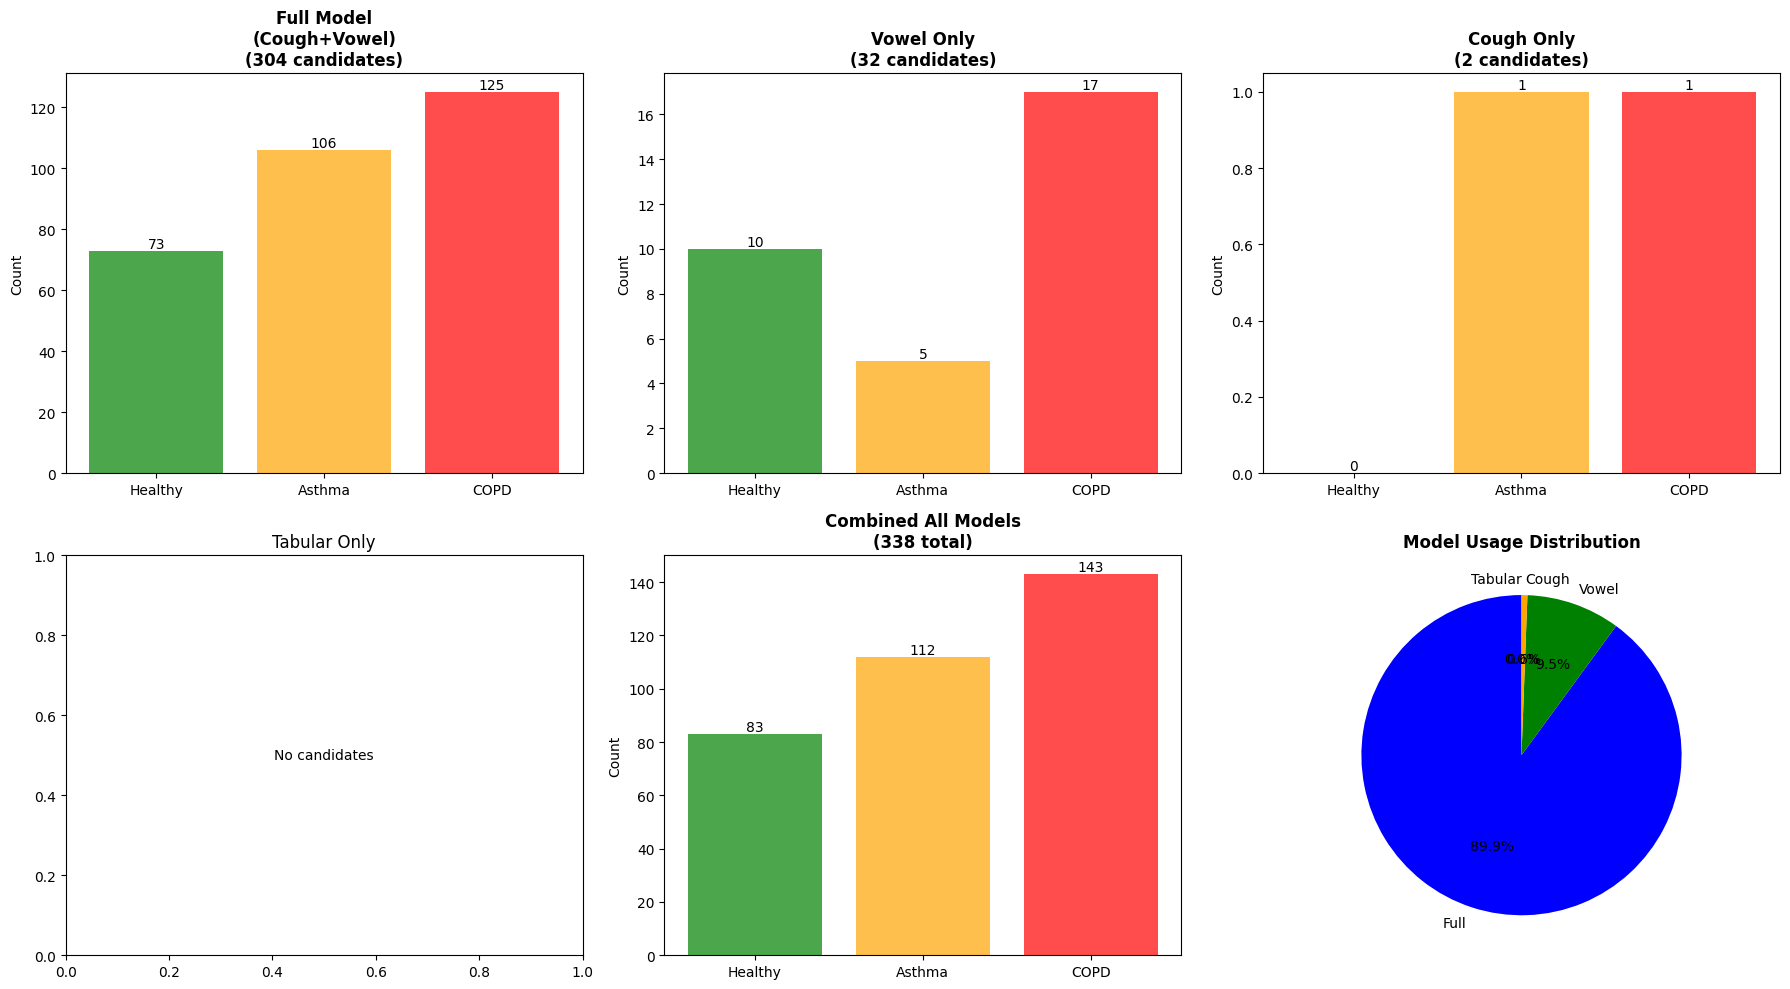

In [79]:
# Combine all predictions for visualization
all_preds_combined = pd.concat([df_full, df_vowel, df_cough, df_tabular], ignore_index=True)

print("="*70)
print("COMBINED PREDICTION SUMMARY")
print("="*70)
print(f"Total predictions: {len(all_preds_combined)}")
print(f"\nBreakdown by model:")
print(f"  - Full Model (Cough+Vowel): {len(df_full)}")
print(f"  - Vowel Only Model: {len(df_vowel)}")
print(f"  - Cough Only Model: {len(df_cough)}")
print(f"  - Tabular Only Model: {len(df_tabular)}")

# Visualize predictions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Distribution per model
for idx, (df_pred, model_name, ax) in enumerate([
    (df_full, 'Full Model\n(Cough+Vowel)', axes[0, 0]),
    (df_vowel, 'Vowel Only', axes[0, 1]),
    (df_cough, 'Cough Only', axes[0, 2]),
    (df_tabular, 'Tabular Only', axes[1, 0])
]):
    if len(df_pred) > 0:
        counts = df_pred['disease'].value_counts().sort_index()
        bars = ax.bar(['Healthy', 'Asthma', 'COPD'], 
                     [counts.get(0, 0), counts.get(1, 0), counts.get(2, 0)],
                     color=['green', 'orange', 'red'], alpha=0.7)
        ax.set_title(f'{model_name}\n({len(df_pred)} candidates)', fontweight='bold')
        ax.set_ylabel('Count')
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom')
    else:
        ax.text(0.5, 0.5, 'No candidates', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(model_name)

# Plot 5: Combined distribution
combined_counts = all_preds_combined['disease'].value_counts().sort_index()
bars = axes[1, 1].bar(['Healthy', 'Asthma', 'COPD'],
                      [combined_counts.get(0, 0), combined_counts.get(1, 0), combined_counts.get(2, 0)],
                      color=['green', 'orange', 'red'], alpha=0.7)
axes[1, 1].set_title(f'Combined All Models\n({len(all_preds_combined)} total)', fontweight='bold')
axes[1, 1].set_ylabel('Count')
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom')

# Plot 6: Model usage distribution
model_sizes = [len(df_full), len(df_vowel), len(df_cough), len(df_tabular)]
axes[1, 2].pie(model_sizes, labels=['Full', 'Vowel', 'Cough', 'Tabular'],
              autopct='%1.1f%%', colors=['blue', 'green', 'orange', 'red'], startangle=90)
axes[1, 2].set_title('Model Usage Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 14. Summary & Final Notes

CATBOOST 4-MODEL ERROR PROPAGATION STRATEGY - FINAL SUMMARY

📊 MODELS TRAINED:
  1. cb_model_full: Tabular + Cough + Vowel (1033 features)
  2. cb_model_vowel: Tabular + Vowel (521 features)
  3. cb_model_cough: Tabular + Cough (521 features)
  4. cb_model_tabular: Tabular only (9 features)

📂 OUTPUT FILES GENERATED:
  1. submission_catboost_full.csv (304 rows)
  2. submission_catboost_vowel_only.csv (32 rows)
  3. submission_catboost_cough_only.csv (2 rows)
  4. submission_catboost_tabular_only.csv (0 rows)

  ✅ TOTAL: 338 rows (Expected: 338)

🎯 STRATEGY HIGHLIGHTS:
  - Error propagation approach inspired by ensemble-starter.ipynb
  - Each candidate uses the most informative model available
  - Separate CSV outputs allow independent model evaluation
  - No merged submission - each model's contribution is transparent

📈 NEXT STEPS:
  - Test each CSV file individually to compare model performance
  - Combine predictions using weighted voting if needed
  - Fine-tune hyperparameters for 

NameError: name 'test_predictions' is not defined

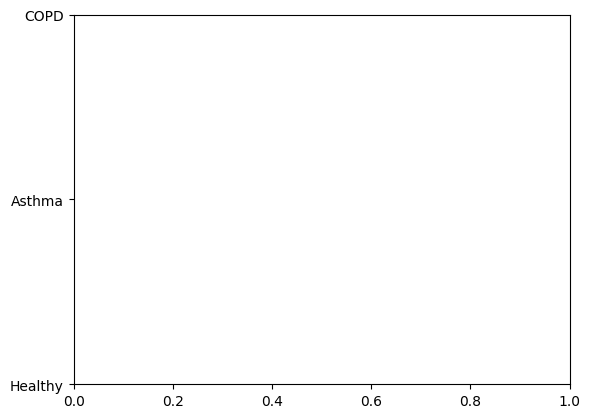

In [80]:
print("="*70)
print("CATBOOST 4-MODEL ERROR PROPAGATION STRATEGY - FINAL SUMMARY")
print("="*70)

print("\n📊 MODELS TRAINED:")
print("  1. cb_model_full: Tabular + Cough + Vowel (1033 features)")
print("  2. cb_model_vowel: Tabular + Vowel (521 features)")
print("  3. cb_model_cough: Tabular + Cough (521 features)")
print("  4. cb_model_tabular: Tabular only (9 features)")

print("\n📂 OUTPUT FILES GENERATED:")
print(f"  1. submission_catboost_full.csv ({len(df_full)} rows)")
print(f"  2. submission_catboost_vowel_only.csv ({len(df_vowel)} rows)")
print(f"  3. submission_catboost_cough_only.csv ({len(df_cough)} rows)")
print(f"  4. submission_catboost_tabular_only.csv ({len(df_tabular)} rows)")
print(f"\n  ✅ TOTAL: {total_predictions} rows (Expected: 338)")

print("\n🎯 STRATEGY HIGHLIGHTS:")
print("  - Error propagation approach inspired by ensemble-starter.ipynb")
print("  - Each candidate uses the most informative model available")
print("  - Separate CSV outputs allow independent model evaluation")
print("  - No merged submission - each model's contribution is transparent")

print("\n📈 NEXT STEPS:")
print("  - Test each CSV file individually to compare model performance")
print("  - Combine predictions using weighted voting if needed")
print("  - Fine-tune hyperparameters for each specialized model")

print("\n" + "="*70)
plt.yticks([0, 1, 2], ['Healthy', 'Asthma', 'COPD'])
plt.xlabel(f'Test Sample Index (n={len(test_predictions)} with embeddings)')
plt.ylabel('Disease Class')
plt.title('Prediction Confidence Heatmap - Samples with Audio Embeddings')
plt.tight_layout()
plt.show()

print("\nAverage confidence per class (samples with embeddings):")
for i, class_name in enumerate(['Healthy', 'Asthma', 'COPD']):
    avg_conf = test_predictions_proba[:, i].mean()
    print(f"  {class_name}: {avg_conf:.3f}")
    
print(f"\nNote: {len(candidates_without_embeddings)} samples without embeddings")
print(f"      were assigned default predictions (not shown in heatmap)")

## 14. Final Summary

### ✅ Training Phase:
- Trained CatBoost model with **1033 features** (9 tabular + 512 cough + 512 vowel)
- Training set: {len(X_train)} samples
- Test/Validation F1 Score (macro): **{test_f1_macro:.4f}**

### ✅ Prediction Phase:
- **Total test samples**: {len(df_test)} candidates
- **With embeddings**: {len(test_candidates_with_both)} candidates → predicted by XGBoost
- **Without embeddings**: {len(candidates_without_embeddings)} candidates → fallback to most common class
- **Final submission**: {len(final_submission_df)} predictions ✅ (matches test file!)

### 📊 Final Prediction Distribution:
- **Healthy (0)**: {final_pred_counts.get(0, 0)} samples ({final_pred_counts.get(0, 0)/len(final_submission_df)*100:.1f}%)
- **Asthma (1)**: {final_pred_counts.get(1, 0)} samples ({final_pred_counts.get(1, 0)/len(final_submission_df)*100:.1f}%)
- **COPD (2)**: {final_pred_counts.get(2, 0)} samples ({final_pred_counts.get(2, 0)/len(final_submission_df)*100:.1f}%)

### 📁 Output File:
- **`submission_catboost.csv`** - Contains {len(final_submission_df)} predictions (ready for submission!)

### ⚠️ Note:
Candidates without complete audio embeddings were assigned predictions using a fallback strategy (most common predicted class). Consider collecting audio data for these candidates to improve accuracy.

### 🎯 Model Ready for Submission!